## Feature Engineering and Data Splitting

In [2]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
import shap

# Download necessary NLTK resources (only needed once)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)


True

In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


In [4]:
# Load the processed dataset
processed_file_path = 'fda_recalls_processed.csv'
final_data = pd.read_csv(processed_file_path)

print("\nProcessed Dataset Information:")
print(f"Shape: {final_data.shape}")
print(f"Columns: {final_data.columns.tolist()}")
print("\nFirst 5 rows:")
print(final_data.head())


Processed Dataset Information:
Shape: (95082, 12)
Columns: ['Product Type', 'Status', 'Recalling Firm State', 'Recalling Firm Country', 'Classification Year', 'Classification Month', 'Classification Day', 'Classification DayOfWeek', 'Reason for Recall_cleaned', 'Product Description_cleaned', 'Has_Recall_URL', 'Event Classification']

First 5 rows:
     Product Type     Status Recalling Firm State Recalling Firm Country  \
0  Food/Cosmetics  Completed              Arizona          United States   
1         Devices    Ongoing         Pennsylvania          United States   
2         Devices    Ongoing         Pennsylvania          United States   
3         Devices    Ongoing         Pennsylvania          United States   
4         Devices    Ongoing         Pennsylvania          United States   

   Classification Year  Classification Month  Classification Day  \
0                 2025                     2                  21   
1                 2025                     2            

In [5]:
final_data.head()

,Product Type,Status,Recalling Firm State,Recalling Firm Country,Classification Year,Classification Month,Classification Day,Classification DayOfWeek,Reason for Recall_cleaned,Product Description_cleaned,Has_Recall_URL,Event Classification
0,Food/Cosmetics,Completed,Arizona,United States,2025,2,21,4,product may contain egg undeclared allergen,food service mombo vanilla soft serve ice crea...,True,Class I
1,Devices,Ongoing,Pennsylvania,United States,2025,2,21,4,complaint locking screw passing locking hole i...,l p mvx anatomic lat fib plate h lt anatomic l...,True,Class II
2,Devices,Ongoing,Pennsylvania,United States,2025,2,21,4,complaint locking screw passing locking hole i...,l p mvx anatomic lat fib plate h rt anatomic l...,True,Class II
3,Devices,Ongoing,Pennsylvania,United States,2025,2,21,4,complaint locking screw passing locking hole i...,l p mvx anatomic lat fib plate h lt anatomic l...,True,Class II
4,Devices,Ongoing,Pennsylvania,United States,2025,2,21,4,complaint locking screw passing locking hole i...,l p mvx anatomic lat fib plate h rt anatomic l...,True,Class II


Convert Categorical Features

In [7]:
# One-hot encode categorical features
categorical_features = ['Product Type', 'Status', 'Recalling Firm State', 'Recalling Firm Country']
encoder = OneHotEncoder(drop='first', sparse_output=False)  
encoded_features = encoder.fit_transform(final_data[categorical_features])

# Convert encoded features to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Drop original categorical columns from the original dataset
final_data_encoded = final_data.drop(columns=categorical_features)

# Concatenate the encoded features with the remaining numerical features
final_data_encoded = pd.concat([final_data_encoded, encoded_df], axis=1)

In [8]:
print("Original dataset shape:", final_data_encoded.shape)

Original dataset shape: (95082, 123)


In [9]:
final_data_encoded['Has_Recall_URL'] = final_data_encoded['Has_Recall_URL'].astype(int)

In [10]:
final_data_encoded.head()
print("Original dataset shape:", final_data_encoded.shape)

Original dataset shape: (95082, 123)


Apply TF-IDF Transformation for text-based columns, reason for recall and product description 

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# 1. Set up TF-IDF with 500 feature limit
tfidf = TfidfVectorizer(
    max_features=500,
    stop_words='english',
    ngram_range=(1, 2)  # captures single words and 2-word phrases
)

# 2. Process text columns
text_cols = ['Reason for Recall_cleaned', 'Product Description_cleaned']
for col in text_cols:
    if col in final_data_encoded.columns:
        # Create TF-IDF features
        tfidf_features = tfidf.fit_transform(final_data_encoded[col].fillna(''))
        
        # Add to dataframe with clear column names
        feature_names = [f"{col}_tfidf_{i}" for i in tfidf.get_feature_names_out()]
        final_data_encoded[feature_names] = pd.DataFrame(tfidf_features.toarray())

# 3. Remove the original text columns
final_df_vectorized = final_data_encoded.drop(columns=text_cols)

# 4. Show results
print(f"Final dataset shape: {final_df_vectorized.shape}")
print("Sample TF-IDF columns:", [c for c in final_df_vectorized.columns if '_tfidf_' in c][:10])


Final dataset shape: (95082, 1121)
Sample TF-IDF columns: ['Reason for Recall_cleaned_tfidf_acceptable', 'Reason for Recall_cleaned_tfidf_acid', 'Reason for Recall_cleaned_tfidf_action', 'Reason for Recall_cleaned_tfidf_ad', 'Reason for Recall_cleaned_tfidf_ad exp', 'Reason for Recall_cleaned_tfidf_additional', 'Reason for Recall_cleaned_tfidf_adequate', 'Reason for Recall_cleaned_tfidf_adequately', 'Reason for Recall_cleaned_tfidf_adequately determined', 'Reason for Recall_cleaned_tfidf_adverse']


In [13]:
final_df_vectorized.head()

,Classification Year,Classification Month,Classification Day,Classification DayOfWeek,Has_Recall_URL,Event Classification,Product Type_Devices,Product Type_Drugs,Product Type_Food/Cosmetics,Product Type_Tobacco,...,Product Description_cleaned_tfidf_water,Product Description_cleaned_tfidf_weight,Product Description_cleaned_tfidf_wheat,Product Description_cleaned_tfidf_white,Product Description_cleaned_tfidf_wound,Product Description_cleaned_tfidf_wt,Product Description_cleaned_tfidf_wt lb,Product Description_cleaned_tfidf_wt oz,Product Description_cleaned_tfidf_www,Product Description_cleaned_tfidf_yellow
0,2025,2,21,4,1,Class I,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.167389,0.0,0.0,0.0,0.0,0.0,0.0
1,2025,2,21,4,1,Class II,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,2025,2,21,4,1,Class II,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,2025,2,21,4,1,Class II,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,2025,2,21,4,1,Class II,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
from sklearn.decomposition import TruncatedSVD

# 1. Select just the TF-IDF features (columns containing '_tfidf_')
tfidf_columns = [col for col in final_df_vectorized.columns if '_tfidf_' in col]
X_tfidf = final_df_vectorized[tfidf_columns]

# 2. Apply Truncated SVD (reduce to 100 components)
n_components = 100  # Adjust based on your needs
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

# 3. Create new column names for SVD components
svd_columns = [f'svd_{i}' for i in range(n_components)]

# 4. Add to original dataframe
final_data_svd = pd.concat([
    final_df_vectorized.drop(tfidf_columns, axis=1),
    pd.DataFrame(X_svd, columns=svd_columns, index=final_df_vectorized.index)
], axis=1)

# 5. Show variance explained
print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.2f}")
print(f"Reduced from {len(tfidf_columns)} to {n_components} features")
print("New shape:", final_data_svd.shape)

Explained variance ratio: 0.47
Reduced from 1000 to 100 features
New shape: (95082, 221)


In [15]:
final_data_svd.head()

,Classification Year,Classification Month,Classification Day,Classification DayOfWeek,Has_Recall_URL,Event Classification,Product Type_Devices,Product Type_Drugs,Product Type_Food/Cosmetics,Product Type_Tobacco,...,svd_90,svd_91,svd_92,svd_93,svd_94,svd_95,svd_96,svd_97,svd_98,svd_99
0,2025,2,21,4,1,Class I,0.0,0.0,1.0,0.0,...,0.043311,-0.033748,0.005338,0.057768,-0.103582,0.018402,-0.209890,0.054413,-0.014415,0.014009
1,2025,2,21,4,1,Class II,1.0,0.0,0.0,0.0,...,-0.151199,0.086023,0.040733,0.031492,-0.011858,-0.023091,-0.027031,0.008996,0.033859,0.006363
2,2025,2,21,4,1,Class II,1.0,0.0,0.0,0.0,...,-0.150261,0.074006,0.054399,0.032344,-0.011221,-0.029438,0.001043,0.008002,0.034269,-0.015540
3,2025,2,21,4,1,Class II,1.0,0.0,0.0,0.0,...,-0.151199,0.086023,0.040733,0.031492,-0.011858,-0.023091,-0.027031,0.008996,0.033859,0.006363
4,2025,2,21,4,1,Class II,1.0,0.0,0.0,0.0,...,-0.150261,0.074006,0.054399,0.032344,-0.011221,-0.029438,0.001043,0.008002,0.034269,-0.015540


In [16]:
from sklearn.model_selection import train_test_split

# Assuming final_df_vectorized is your final dataset with features
X = final_data_svd.drop(columns='Event Classification')  # Feature columns
y = final_data_svd['Event Classification']  # Target column

# Split into 80% train + validation, 20% test (stratified sampling)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Split train + validation into 70% train, 10% validation (stratified sampling)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, stratify=y_train_val, random_state=42)

# Check the shape of the splits
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (66556, 220)
Validation set shape: (9509, 220)
Test set shape: (19017, 220)


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# Create a progress bar function for Random Forest
def train_with_progress_bar_rf(model, X_train, y_train):
    with tqdm(total=len(X_train), desc="Training Random Forest") as pbar:
        model.fit(X_train, y_train)
        pbar.update(len(X_train))  # Update progress after training

# Initialize Random Forest model with class_weight='balanced' to handle class imbalance
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the Random Forest model on the training set with progress bar
train_with_progress_bar_rf(rf_model, X_train, y_train)

# Make predictions on the validation set
y_val_pred_rf = rf_model.predict(X_val)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
rf_report = classification_report(y_val, y_val_pred_rf)

print(f"Random Forest Accuracy on Validation Set: {rf_accuracy:.4f}")
print("Random Forest Classification Report on Validation Set:")
print(rf_report)


Training Random Forest: 100%|████████████| 66556/66556 [01:24<00:00, 784.70it/s]


Random Forest Accuracy on Validation Set: 0.9211
Random Forest Classification Report on Validation Set:
              precision    recall  f1-score   support

     Class I       0.96      0.87      0.91      2011
    Class II       0.91      0.98      0.95      6733
   Class III       0.88      0.52      0.65       765

    accuracy                           0.92      9509
   macro avg       0.92      0.79      0.84      9509
weighted avg       0.92      0.92      0.92      9509



Class I: Precision of 0.96 means that when the model predicts Class I, it's correct 96% of the time.

Recall of 0.87 indicates that out of all actual Class I instances, the model successfully identifies 87% of them.

F1-Score of 0.91 is a good balance between precision and recall. It suggests that the model is performing well in classifying Class I.

Class II (Precision: 0.91, Recall: 0.98, F1-Score: 0.95):

Precision of 0.91 means that for the instances predicted as Class II, 91% are correct.

Recall of 0.98 is very high, meaning that the model successfully detects 98% of actual Class II instances.

F1-Score of 0.95 indicates a very good performance for Class II, with a nice balance between precision and recall.

Class III (Precision: 0.88, Recall: 0.52, F1-Score: 0.65):

Precision of 0.88 means that when the model predicts Class III, it is correct 88% of the time.

Recall of 0.52 is low, meaning that the model only identifies 52% of the actual Class III instances. This indicates that Class III is underrepresented and difficult for the model to correctly classify.

F1-Score of 0.65 reflects the poor recall for Class III, as recall has a large impact on the F1-Score. The model struggles to correctly identify Class III.

In [19]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Print class mapping to verify encoding
print(f"Class Mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")


Class Mapping: {'Class I': np.int64(0), 'Class II': np.int64(1), 'Class III': np.int64(2)}


In [20]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# Setting scale_pos_weight to balance classes (ratio of majority/minority)
class_counts = y_train.value_counts()
scale_pos_weight = class_counts.min() / class_counts.max()

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

# Train the model with a progress bar
print("Training XGBoost...")
for i in tqdm(range(1, 101)):
    xgb_model.n_estimators = i
    xgb_model.fit(X_train, y_train_encoded, eval_set=[(X_val, y_val_encoded)], verbose=False)

# Predictions on validation set
val_preds = xgb_model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val_encoded, val_preds)
print(f"XGBoost Accuracy on Validation Set: {accuracy:.4f}")
print("XGBoost Classification Report on Validation Set:")
print(classification_report(y_val_encoded, val_preds, target_names=label_encoder.classes_))


Training XGBoost...


100%|█████████████████████████████████████████| 100/100 [11:44<00:00,  7.04s/it]

XGBoost Accuracy on Validation Set: 0.8898
XGBoost Classification Report on Validation Set:
              precision    recall  f1-score   support

     Class I       0.91      0.81      0.86      2011
    Class II       0.89      0.97      0.93      6733
   Class III       0.85      0.40      0.55       765

    accuracy                           0.89      9509
   macro avg       0.88      0.73      0.78      9509
weighted avg       0.89      0.89      0.88      9509



Class I: High precision (0.91), but recall is lower (0.81) → The model correctly identifies most Class I instances, but some are misclassified.

Class II: High precision (0.89) and recall (0.97) → The model does well in identifying Class II recalls.

Class III: Decent precision (0.85), but very low recall (0.40) → The model struggles to capture all Class III instances.



In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Standardizing the features (Neural Networks perform better with scaled data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define the MLP model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # Two hidden layers with 128 and 64 neurons
    activation='relu',
    solver='adam',
    max_iter=200,  # Can be increased if convergence isn't reached
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

# Training with a progress bar
print("Training MLPClassifier...")
for _ in tqdm(range(1, 2)):  # Fake loop to show progress bar
    mlp_model.fit(X_train_scaled, y_train_encoded)

# Predictions on validation set
val_preds = mlp_model.predict(X_val_scaled)

# Evaluation
accuracy = accuracy_score(y_val_encoded, val_preds)
print(f"MLPClassifier Accuracy on Validation Set: {accuracy:.4f}")
print("MLPClassifier Classification Report on Validation Set:")
print(classification_report(y_val_encoded, val_preds))


Training MLPClassifier...


100%|█████████████████████████████████████████████| 1/1 [00:35<00:00, 35.29s/it]

MLPClassifier Accuracy on Validation Set: 0.9171
MLPClassifier Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2011
           1       0.94      0.95      0.94      6733
           2       0.73      0.63      0.68       765

    accuracy                           0.92      9509
   macro avg       0.86      0.83      0.84      9509
weighted avg       0.91      0.92      0.92      9509



Class I (Precision: 0.91, Recall: 0.91, F1-score: 0.91) This class has both good precision and recall, indicating that the model is correctly identifying the instances from this class and not misclassifying too many.

Class II (Precision: 0.94, Recall: 0.95, F1-score: 0.94 This is the best-performing class. The model has high precision and recall, indicating a balanced performance in identifying Class 1 instances correctly.

Class III (Precision: 0.73, Recall: 0.63, F1-score: 0.68) Class 2 has lower performance compared to Class 0 and Class 1. The precision is decent, but the recall is significantly lower, meaning the model struggles more with correctly identifying instances of Class 2.

SHAP

100%|===================| 2994/3000 [06:50<00:00]        

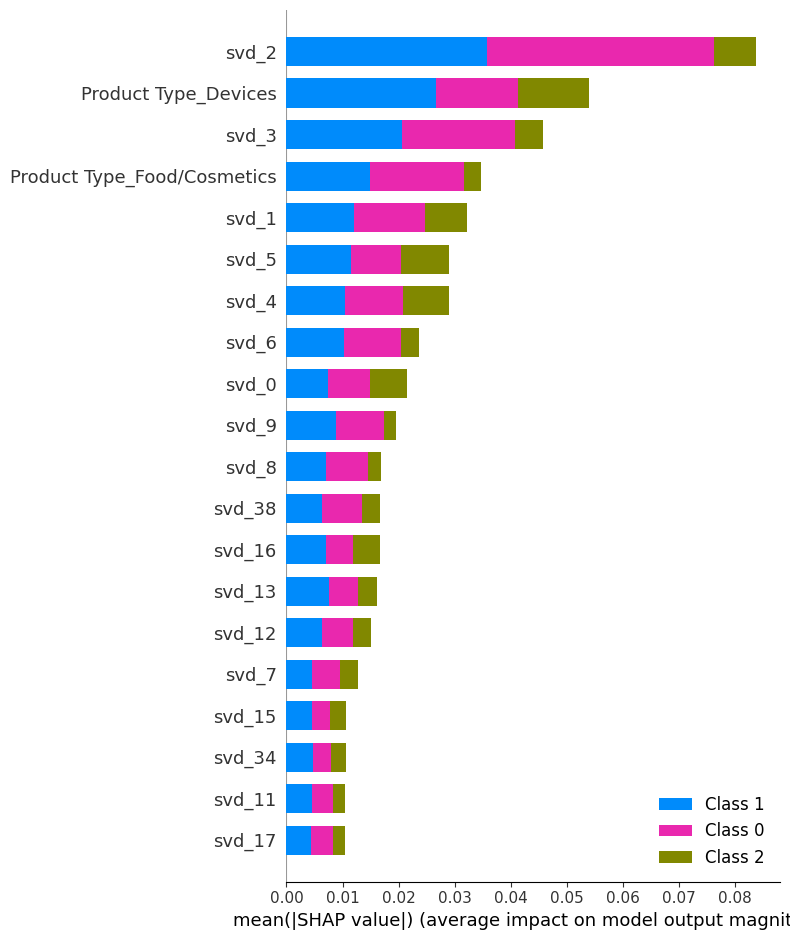

In [25]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 1. Use consistent samples for both calculations
sample_indices = np.random.choice(X_train.index, 1000, replace=False)
X_sample = X_train.loc[sample_indices]

# 2. SHAP explanation
explainer_rf = shap.TreeExplainer(rf_model, data=X_train.sample(100))
shap_values_rf = explainer_rf.shap_values(X_sample)

# 3. Global feature importance 
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_rf, X_sample, plot_type="bar")

<Figure size 640x480 with 0 Axes>

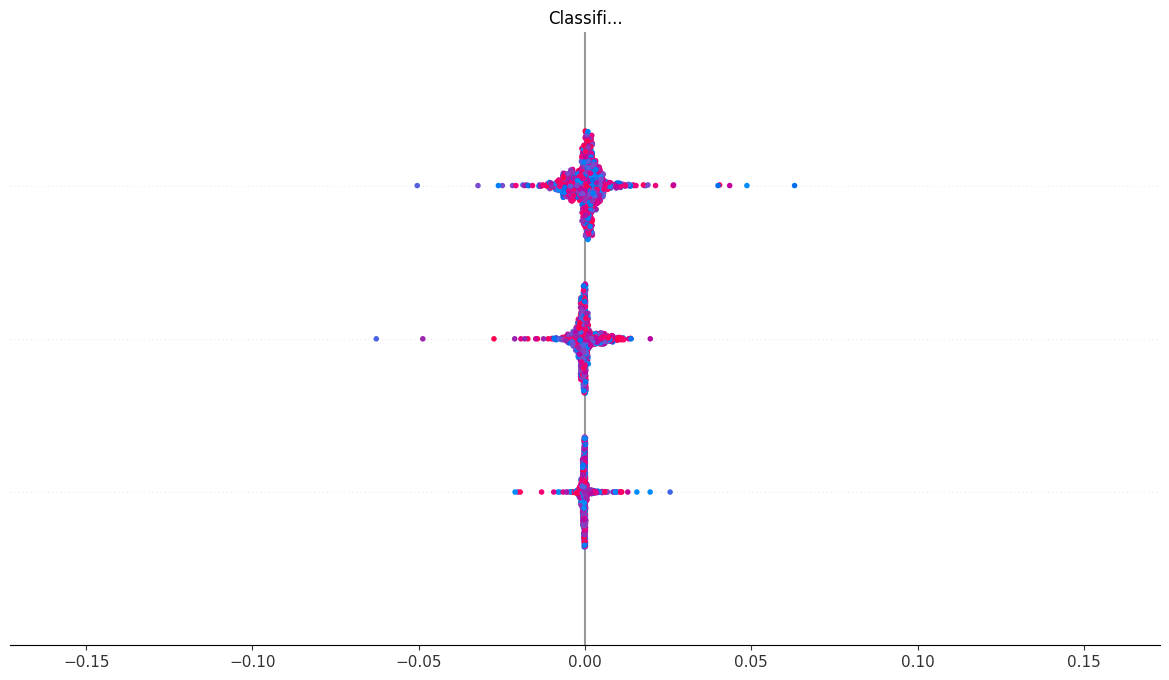

In [26]:
# For a detailed view of how features impact predictions
shap.summary_plot(shap_values_rf, X_sample)  

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer, recall_score, f1_score
import numpy as np
from tqdm import tqdm

# Define a custom scorer that prioritizes recall for Class III
def class_iii_recall(y_true, y_pred):
    # Get recall score specifically for Class III
    # Assuming Class III is labeled as 2 (0-indexed) or "Class III"
    class_label = 2 if isinstance(y_true[0], (int, float)) else "Class III"
    return recall_score(y_true, y_pred, labels=[class_label], average=None)[0]

# Create a scorer that combines overall f1 and Class III recall
class_iii_scorer = make_scorer(class_iii_recall)

# Define parameter grid focusing on parameters that can help with imbalanced classes
param_grid = {
    'n_estimators': [200, 300, 500, 700],
    'max_depth': [None, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],
    'class_weight': ['balanced', 'balanced_subsample'],
    # Add sample weights options
    'max_samples': [0.7, 0.8, 0.9, 1.0]
}

# Create a base model
rf = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV with a focus on Class III recall
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=3,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring={
        'f1_weighted': 'f1_weighted',
        'recall_class_iii': class_iii_scorer
    },
    refit='recall_class_iii'  # Optimize for Class III recall
)

# Fit the model
rf_random.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", rf_random.best_params_)
print("Best score (Class III recall):", rf_random.best_score_)

# Evaluate on validation set
y_val_pred = rf_random.best_estimator_.predict(X_val)
print(classification_report(y_val, y_val_pred))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 0

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_sco

Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 15, 'class_weight': 'balanced', 'bootstrap': True}
Best score (Class III recall): nan
              precision    recall  f1-score   support

     Class I       0.76      0.89      0.82      2011
    Class II       0.94      0.85      0.89      6733
   Class III       0.51      0.75      0.61       765

    accuracy                           0.85      9509
   macro avg       0.74      0.83      0.77      9509
weighted avg       0.87      0.85      0.85      9509



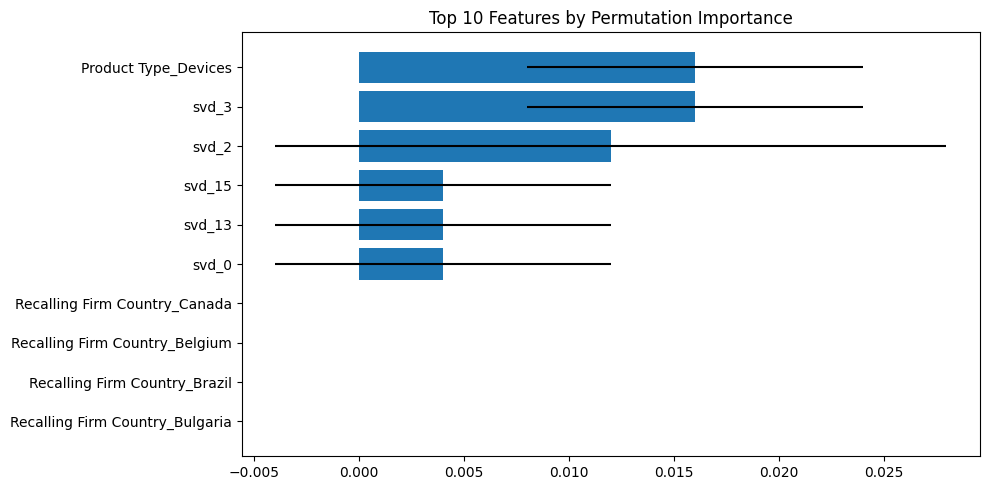

In [33]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance  # <-- Missing import
from tqdm import tqdm

# 1. Reduced sample size for faster computation
sample_size = 50
sample_indices = np.random.choice(X_train.index, min(sample_size, len(X_train)), replace=False)
X_sample = X_train.loc[sample_indices]
y_sample = y_train.loc[sample_indices]  # <-- Need target values for permutation importance

# 2. Compute permutation importance (faster alternative to SHAP)
result = permutation_importance(
    rf_model,
    X_sample,
    y_sample,
    n_repeats=5,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# 3. Get top 10 features for Class III (assuming it's one of your classes)
sorted_idx = result.importances_mean.argsort()[::-1][:10]

# 4. Plot results
plt.figure(figsize=(10, 5))
plt.barh(
    range(10),
    result.importances_mean[sorted_idx][::-1],
    xerr=result.importances_std[sorted_idx][::-1]
)
plt.yticks(range(10), X_train.columns[sorted_idx][::-1])
plt.title("Top 10 Features by Permutation Importance")
plt.tight_layout()
plt.show()

In [37]:
# Keep only features with positive importance
important_features = X_train.columns[result.importances_mean > 0]
X_train_reduced = X_train[important_features]

In [39]:
# Focus on Class III only
class_iii_mask = (y_train == 'Class III')
result_class_iii = permutation_importance(
    rf_model,
    X_train[class_iii_mask],
    y_train[class_iii_mask],
    n_repeats=5,
    random_state=42
)

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Use your selected features
X_train_selected = X_train[important_features]

# Parameter grid focusing on Class III performance
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [{'Class I': 1, 'Class II': 1, 'Class III': 3},  # Higher weight for Class III
                    {'Class I': 1, 'Class II': 1, 'Class III': 5},
                    'balanced'],
    'max_features': ['sqrt', 'log2', 0.5]  # Important with many SVD features
}

# Focus on Class III recall during scoring
rf = RandomForestClassifier(random_state=42)
search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=5,
    scoring='recall_macro',  # Or make custom scorer focusing on Class III
    cv=5,
    n_jobs=-1,
    verbose=2
)

search.fit(X_train_selected, y_train)
best_rf = search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END class_weight={'Class I': 1, 'Class II': 1, 'Class III': 3}, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  15.0s
[CV] END class_weight={'Class I': 1, 'Class II': 1, 'Class III': 3}, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  18.3s
[CV] END class_weight=balanced, max_depth=30, max_features=0.5, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  29.4s
[CV] END class_weight={'Class I': 1, 'Class II': 1, 'Class III': 5}, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  50.8s
[CV] END class_weight=balanced, max_depth=20, max_features=0.5, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  42.6s
[CV] END class_weight={'Class I': 1, 'Class II': 1, 'Class III': 3}, max_depth=10, max_features=log2, min_samples_l

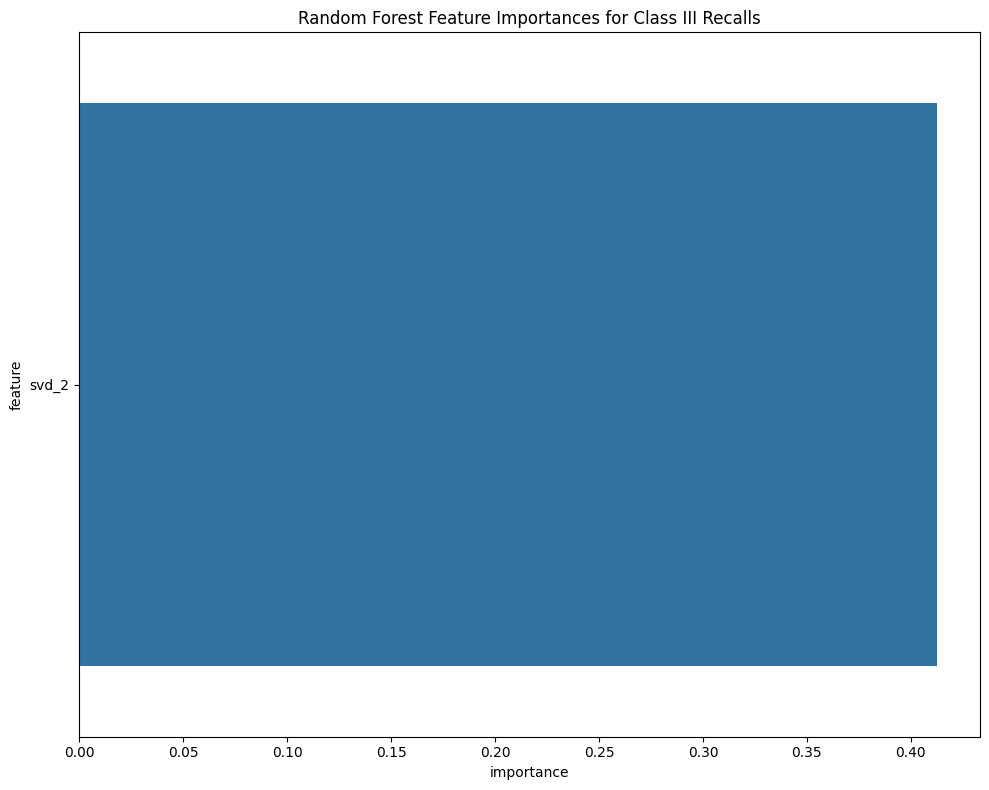

In [51]:
# Corrected Class-Specific Feature Importance Analysis

# Get the index of Class III
class_iii_idx = np.where(best_rf.classes_ == 'Class III')[0][0]

# For Random Forest, we need to properly handle multi-class feature importances
n_classes = len(best_rf.classes_)
n_features = len(important_features)

# Initialize array to store class-specific importances
class_iii_importances = np.zeros(n_features)

# Calculate mean importance across all trees
for tree in best_rf.estimators_:
    # Get all feature importances (shape: [n_classes, n_features])
    tree_importances = tree.tree_.compute_feature_importances(normalize=False)
    
    # Reshape to separate class importances (if stored this way)
    if tree_importances.ndim == 2:  # Some implementations store per-class
        class_iii_importances += tree_importances[class_iii_idx]
    else:  # Standard scikit-learn stores aggregated
        class_iii_importances += tree_importances

# Normalize by number of trees
class_iii_importances /= len(best_rf.estimators_)

# Verify lengths match
assert len(important_features) == len(class_iii_importances), \
    f"Mismatch: {len(important_features)} features but {len(class_iii_importances)} importance values"

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': important_features,
    'importance': class_iii_importances
}).sort_values('importance', ascending=False)

# Plot top 20 features for Class III
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title('Random Forest Feature Importances for Class III Recalls')
plt.tight_layout()
plt.show()

In [55]:
# Get the top 5 most important features
top_features = importance_df.head(5)['feature'].tolist()
print(f"Top 5 features for Class III: {top_features}")

# Create a reduced dataset with just these features
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

Top 5 features for Class III: ['svd_2']


In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np

# 1. Combine your text columns (adjust column names as needed)
final_data_encoded['combined_text'] = final_data_encoded['Reason for Recall_cleaned'].fillna("") + " " + final_data_encoded['Product Description_cleaned'].fillna("")

# 2. Recreate your TF-IDF pipeline (adjust parameters to match your original)
vectorizer = TfidfVectorizer(
    max_features=5000,       # Match what you used originally
    stop_words='english',    # If you used this
    ngram_range=(1, 2)      # If you used ngrams
)
tfidf_matrix = vectorizer.fit_transform(final_data_encoded['combined_text'])

# 3. Recreate SVD transformation (match your original n_components)
svd = TruncatedSVD(
    n_components=50,         # Match your original setting
    random_state=42
)
svd_features = svd.fit_transform(tfidf_matrix)

# 4. Analyze svd_2 component
feature_names = vectorizer.get_feature_names_out()
component_weights = svd.components_[2]  # For svd_2

# Get top 20 terms with highest absolute weights
top_terms_idx = np.argsort(np.abs(component_weights))[-20:][::-1]
top_terms = [(feature_names[i], component_weights[i]) for i in top_terms_idx]

# 5. Create a detailed term analysis
terms_df = pd.DataFrame(top_terms, columns=['Term', 'Weight'])
terms_df['Absolute_Weight'] = terms_df['Weight'].abs()
terms_df['Direction'] = terms_df['Weight'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

print("Top terms contributing to svd_2:")
print(terms_df.sort_values('Absolute_Weight', ascending=False))

Top terms contributing to svd_2:
                      Term    Weight  Absolute_Weight Direction
0                       ml  0.275911         0.275911  Positive
1                       oz -0.243422         0.243422  Negative
2                      upc -0.200596         0.200596  Negative
3                       mg  0.195422         0.195422  Positive
4                      net -0.175403         0.175403  Negative
5                       wt -0.167047         0.167047  Negative
6                   net wt -0.166056         0.166056  Negative
7                assurance  0.160582         0.160582  Positive
8                       lb -0.158728         0.158728  Negative
9                sterility  0.156841         0.156841  Positive
10                 product -0.152443         0.152443  Negative
11                    lack  0.146800         0.146800  Positive
12                listeria -0.141960         0.141960  Negative
13                   mg ml  0.140825         0.140825  Positive
14     

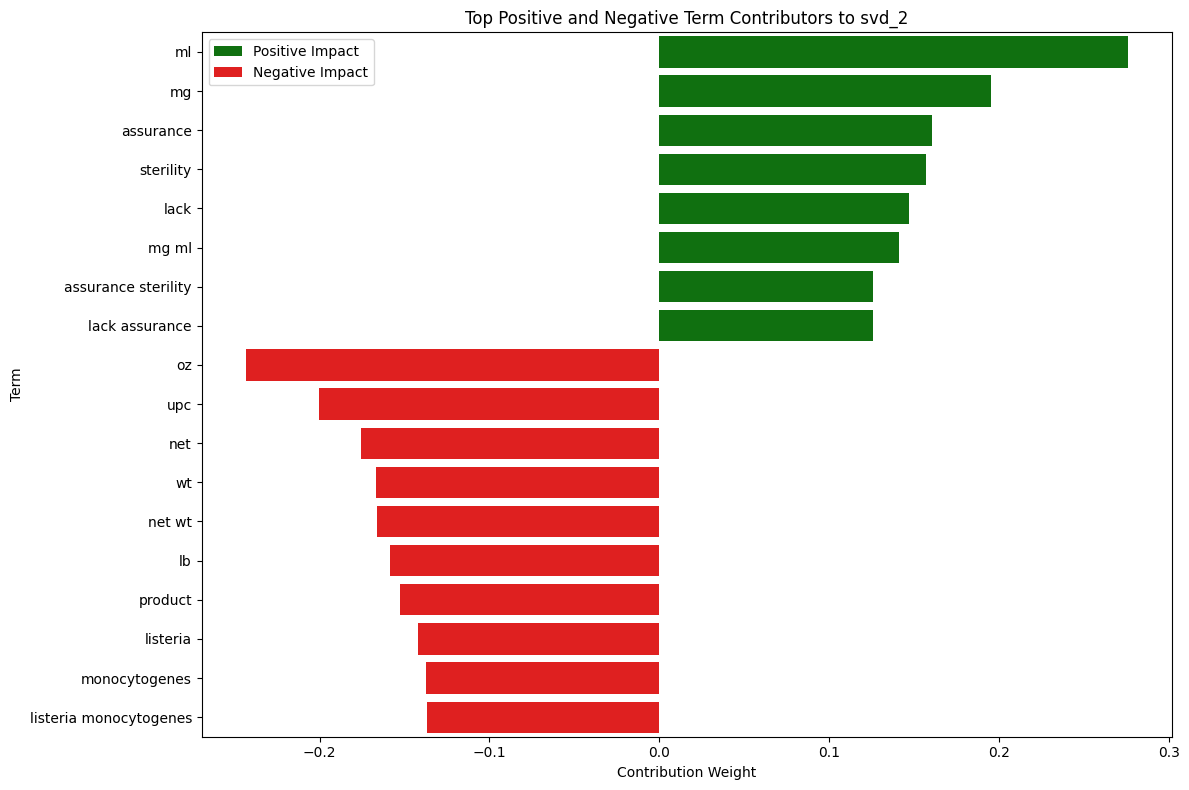

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot positive and negative contributors separately
plt.figure(figsize=(12, 8))

# Positive contributors
positive_terms = terms_df[terms_df['Direction'] == 'Positive'].head(10)
sns.barplot(x='Weight', y='Term', data=positive_terms, color='green', label='Positive Impact')

# Negative contributors
negative_terms = terms_df[terms_df['Direction'] == 'Negative'].head(10)
sns.barplot(x='Weight', y='Term', data=negative_terms, color='red', label='Negative Impact')

plt.title('Top Positive and Negative Term Contributors to svd_2')
plt.xlabel('Contribution Weight')
plt.ylabel('Term')
plt.legend()
plt.tight_layout()
plt.show()

In [81]:
# Create new features based on key terms
final_data_encoded['contains_high_risk_terms'] = final_data_encoded['combined_text'].str.contains('|'.join(positive_terms['Term']), case=False).astype(int)

In [83]:
def classify_with_rules(row):
    # If contains multiple high-risk terms
    if sum(term in row['combined_text'].lower() for term in top_positive_terms) >= 2:
        return 'Class III'
    # Otherwise use model prediction
    return model.predict([row[selected_features]])[0]